<a href="https://colab.research.google.com/github/ChamathkaM2001/Production-Based-Energy-Prediction-for-Sustainable-Manufacturing/blob/main/XGBoost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Outlier Removal

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np  # Import NumPy

# Load the dataset
imported_data = r"/content/import_data.csv"
data = pd.read_csv(imported_data)

# Creating DataFrame
df = pd.DataFrame(data)

# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    df_no_outliers = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_no_outliers

# Columns with outliers
columns_with_outliers = ['Total(Tonnage)', 'Total(Energy-Mixing)', 'Total(Packing)', 'Total(HVAC)', 'Total(Lightning)', 'Total(Air curtain)', 'Total(Dihimudity)', 'Actual Energy']

# Remove outliers from X and y
df_no_outliers = remove_outliers(df, columns_with_outliers)

# Update X and y after removing outliers
X_no_outliers = df_no_outliers[['Total(Tonnage)', 'Total(Energy-Mixing)', 'Total(Packing)', 'Total(HVAC)', 'Total(Lightning)', 'Total(Air curtain)', 'Total(Dihimudity)']]
y_no_outliers = df_no_outliers['Actual Energy']



# Splitting Data and Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBRegressor()

# Model Fitting, Prediction, and Evaluation

In [ ]:
# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Calculating metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared score (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 42577.17815045279
Mean Absolute Error (MAE): 71.00436498763713
R-squared score (R2): 0.8173570576955318
Root Mean Squared Error (RMSE): 206.34238088781663


# Visualization

## Actual vs predicted

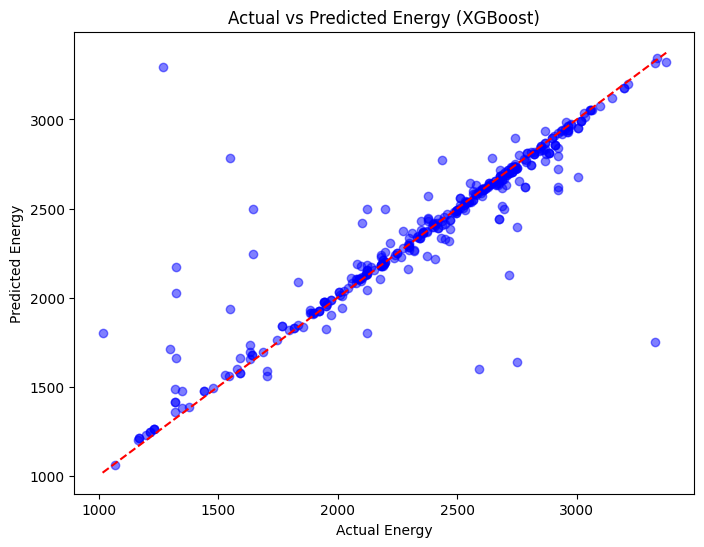

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title('Actual vs Predicted Energy (XGBoost)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line
plt.show()



## Actual (line) vs Predicted (Scatter)

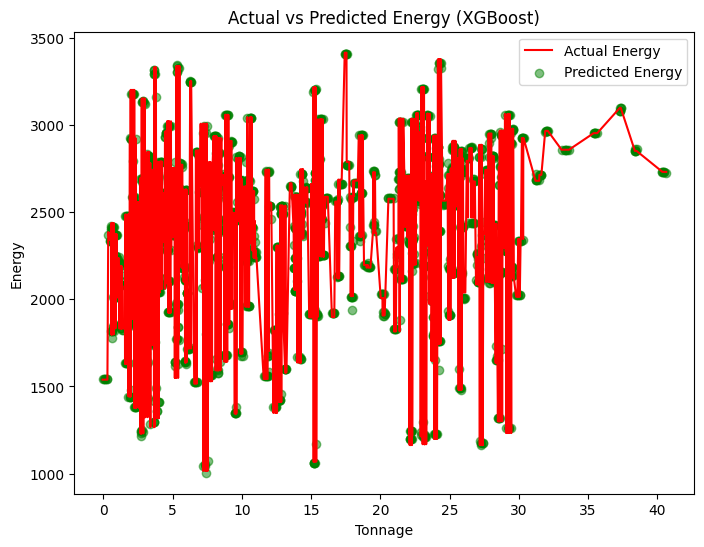

In [ ]:
import matplotlib.pyplot as plt

# Sort the dataset by 'Total(Tonnage)' for visualization
sorted_df = df_no_outliers.sort_values(by='Total(Tonnage)')

# Get sorted values for X_test and y_test
X_test_sorted = sorted_df[['Total(Tonnage)', 'Total(Energy-Mixing)', 'Total(Packing)', 'Total(HVAC)', 'Total(Lightning)', 'Total(Air curtain)', 'Total(Dihimudity)']]
y_test_sorted = sorted_df['Actual Energy']

# Get sorted predicted values based on the sorted 'Total(Tonnage)' values
y_pred_sorted = model.predict(X_test_sorted)

# Plotting actual energy values as a line plot
plt.figure(figsize=(8, 6))
plt.plot(sorted_df['Total(Tonnage)'], y_test_sorted, color='red', label='Actual Energy')

# Plotting predicted energy values as a scatter plot
plt.scatter(sorted_df['Total(Tonnage)'], y_pred_sorted, color='green', alpha=0.5, label='Predicted Energy')

plt.xlabel('Tonnage')
plt.ylabel('Energy')
plt.title('Actual vs Predicted Energy (XGBoost)')
plt.legend()
plt.show()


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
model = XGBRegressor()

# Define hyperparameters and their ranges for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_result.best_params_

# Initialize the XGBoost model with the best hyperparameters
best_model = XGBRegressor(**best_params)

# Train the model with the best hyperparameters
best_model.fit(X_train, y_train)

# Making predictions
y_pred = best_model.predict(X_test)

# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Evaluating the model
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared score (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 43392.60670919467
Mean Absolute Error (MAE): 89.29686168914145
R-squared score (R2): 0.8138591210619335
Root Mean Squared Error (RMSE): 208.30892133846467


# Visualization after Hyperparameter Tuning

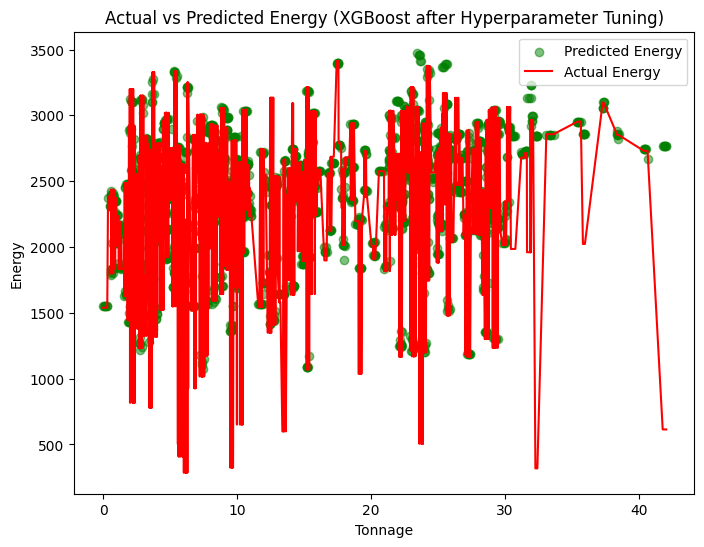

In [ ]:
import matplotlib.pyplot as plt

# Sort the dataset by 'Total(Tonnage)'
sorted_df = df.sort_values(by='Total(Tonnage)')

# Get sorted values for X_test and y_test
X_test_sorted = sorted_df[['Total(Tonnage)', 'Total(Energy-Mixing)', 'Total(Packing)', 'Total(HVAC)', 'Total(Lightning)', 'Total(Air curtain)', 'Total(Dihimudity)']]
y_test_sorted = sorted_df['Actual Energy']

# Get sorted predicted values based on the sorted 'Total(Tonnage)' values using the best model
y_pred_sorted = best_model.predict(X_test_sorted)

# Scatter plot for predicted values and line plot for actual values
plt.figure(figsize=(8, 6))

# Plotting predicted energy values (tonnage on x-axis, predicted energy on y-axis in green color)
plt.scatter(X_test_sorted['Total(Tonnage)'], y_pred_sorted, color='green', alpha=0.5, label='Predicted Energy')

# Line plot for actual energy values (tonnage on x-axis, actual energy on y-axis in red color)
plt.plot(X_test_sorted['Total(Tonnage)'], y_test_sorted, color='red', label='Actual Energy')

plt.xlabel('Tonnage')
plt.ylabel('Energy')
plt.title('Actual vs Predicted Energy (XGBoost after Hyperparameter Tuning)')
plt.legend()
plt.show()


# Residual Analysis

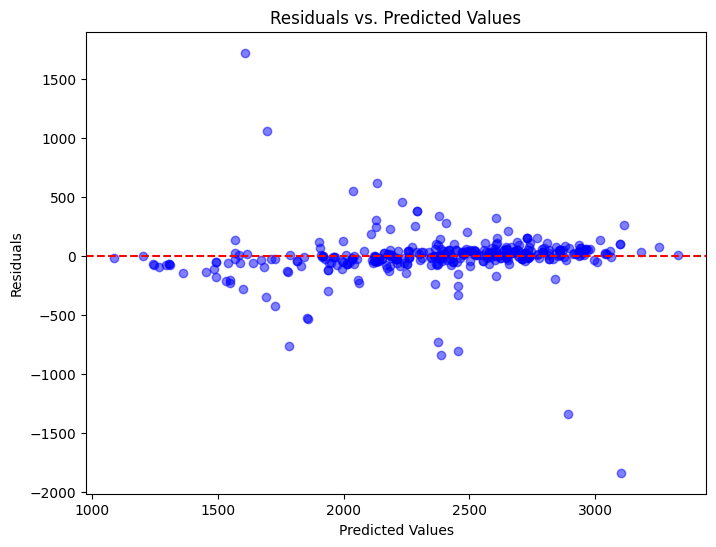

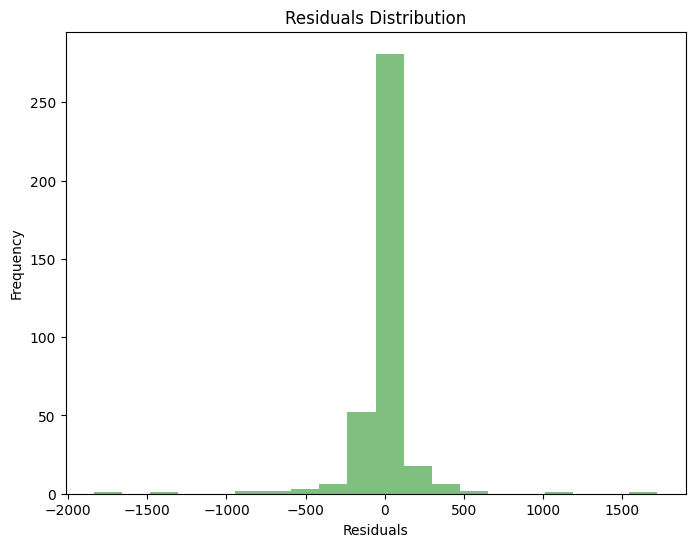

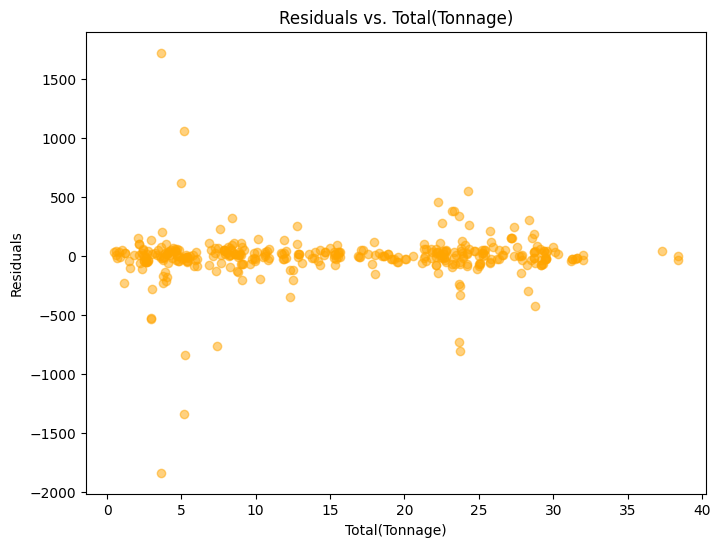

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

import matplotlib.pyplot as plt

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Plot residuals distribution
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='green', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

# Plot residuals vs. individual features (if needed)
# Example: Residuals vs. 'Total(Tonnage)'
plt.figure(figsize=(8, 6))
plt.scatter(X_test['Total(Tonnage)'], residuals, color='orange', alpha=0.5)
plt.xlabel('Total(Tonnage)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Total(Tonnage)')
plt.show()
